## Описание проекта
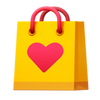

**Описание:**
Заказчик предоставил обезличенные данные по истории покупок трех интернет-магазинов

**Цель проекта:** нужно разработать решение, которое будет предсказывать, совершит ли пользователь повторную покупку в течение 30 дней.
Срок выполнения: 2 недели 


**Наша задача** - построить модель классификации, которая должна принять решение останется клиент у продавца или уйдет
(бинарная классификация).


**Ход исследования:**

Данные для исследования мы получим из файлов, предоставленных заказчиком.
Метрика качества решения будет выбрана после выбора стратегии решения и полноценного исследованиях данных.


**Данные:**   

`marketplace-purchases.csv`- мультикатегорийный магазин с посещаемостью более 8 млн сессий в месяц   
`apparel-purchases.csv` - магазин одежды, по характеристикам похожий на маркетплейс   
`gifts-purchases.csv` – магазин подарков, очень маленький   


**Описание данных**

В датасете представлены данные о покупках (купленных товарах):   
`client_id` – идентификатор клиента;   
`quantity` – количество товара в заказе;      
`price` – цена 1 единицы товара в заказе;      
`message_id` – идентификатор сообщения из рассылки;   
`date` – дата покупки.   


**План исследования построения модели для прогнозирования повторных покупок в интернет-магазинах:**

1. Загрузка данных и первичное ознакомление: 

   - Загрузка данных из файлов marketplace-purchases.csv, apparel-purchases.csv, gifts-purchases.csv
   - Просмотр первых строк каждого датасета для ознакомления с содержимым
   - Проверка наличия пропущенных значений и необходимость их обработки

2. Предварительная обработка данных:

   - Объединение данных из разных датасетов, если нужно
   - Преобразование типов данных в соответствующий формат
   - Исследование распределения признаков и  для выявления особенностей

3. Разведочный анализ и создание новых признаков:

   - Создание целевой переменной
   - Проведение анализа распределения целевой переменной
   - Создание новых признаков на основе имеющихся данных
   - Визуализация важных характеристик датасета

4. Обоснование решения:

   - Формулирование задачи как задачи бинарной классификации
   - Выбор метрики качества для оценки модели с учетом особенностей таргета
   - Разделение данных на обучающую и тестовую выборки
   - Оценка корреляции между признаками и целевой переменной
   - Использование методов отбора признаков для выбора наиболее значимых

5. Выбор и обучение моделей, отбор финального набора признаков:

   - Подбор модели для обучения
   - Обучение моделей на обучающих данных
   - Проверка модели на адекватность
   - Проведение анализа важности признаков с использованием методов, таких как Feature Importance
   - Оценка влияния каждого признака на прогноз модели
   - Выбор наиболее значимых признаков для улучшения модели

6. Итоговая оценка качества лучшей модели:

   - Расчет дополнительных метрик качества
   - Вывод на основе полученной метрики 
   - Оценка качества модели на тестовой выборке   

7. Общий вывод и формулирование рекомендаций:

   - Сводный анализ результатов работы
   - Формулирование общих выводов о построенной модели
   - Составление рекомендаций для бизнеса 

## 1.Загрузка и первичное ознакомление с данными

Импортируем необходимые для анализа данных библиотеки.

Считаем данные из csv-файлов в датафреймы и сохраним в переменные market,apparel и gifts соответственно.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from catboost import CatBoostClassifier, Pool

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    accuracy_score,
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score,
    roc_curve, 
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)

from tqdm import tqdm

In [2]:
# введем константы
RANDOM_STATE = 12345
PROMO = 0.2

### Первичный обзор данных
Загрузим имеющиеся датасеты и посмотрим на данные.

In [3]:
market = pd.read_csv('marketplace-purchases.csv')
market.head()

,client_id,quantity,price,message_id,created_at,date
0,1515915625440944408,1,6298.0,1515915625440944408-1752-6450b79616277,2023-05-02,2023-05-02 08:49:57
1,1515915625440992498,1,7318.0,1515915625440992498-1818-646b35d089c98,2023-05-22,2023-05-22 13:52:13
2,1515915625441026424,1,65798.0,1515915625441026424-1802-64634e24a2cb9,2023-05-17,2023-05-17 11:21:04
3,1515915625441118180,1,5598.0,1515915625441118180-1820-646c9444ebf39,2023-05-23,2023-05-23 19:02:53
4,1515915625441124500,1,77998.0,1515915625441124500-1825-646ed5cf4d5ed,2023-05-25,2023-05-25 07:46:52


In [4]:
apparel = pd.read_csv('apparel-purchases.csv')
apparel.head()

,client_id,quantity,price,date,message_id,recommended_by
0,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
1,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
2,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
3,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
4,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message


In [5]:
gifts = pd.read_csv('gifts-purchases.csv')
gifts.head()

,client_id,quantity,price,date,message_id,recommended_by
0,1515915625803894158,1,8943.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
1,1515915625803894158,1,46369.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
2,1515915625803894158,1,4666.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
3,1515915625803894158,1,11963.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
4,1515915625803894158,1,13107.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message


Названия столбцов практически соответствуют описанию данных от заказчика. Следует уточнить относительно даты: что такое `created_at`. Столбцы `message_id` и `recommended_by` в данном исследовании использоваться не будут.

In [6]:
# выберем стиль для оформления графиков
plt.style.use('fivethirtyeight')

In [7]:
# напишем функцию для вывода основной информации о датасете
def main_info(data):
    """
     Функция для отображения основной информации о датафрейме, включая:
    - Информацию о структуре данных
    - Период представления данных
    - Количество строк и столбцов
    - Числовое описание данных
    - Количество строк-дубликатов
    - Количество и процент пропущенных значений по признакам
    - Типы признаков
    
    Параметры:
    data (pd.DataFrame): Датафрейм, для которого необходимо вывести информацию
    
    Возвращает:
    None
    """
    print(f'Основная информация о датафрейме')
    print()
    display(data.info())
    # посмотрим период за который у нас есть данные в обучающей выборке
    max_date = data['date'].max()
    min_date = data['date'].min()
    print(f'Данные представлены за период c {min_date} по {max_date}')
    print()
    
    print(f'Количество строк датасета {data.shape[0]}')
    print(f'Количество столбцов {data.shape[1]}')
    print()

    print(f'Числовое описание данных')
    display(data.describe().style.background_gradient())
    print()

    print(f'Количество строк-дубликатов')
    display(data.duplicated().sum())
    print()

    print(f'Количество пропусков в процентном соотношении')
    display(pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient())
    print()

    print(f'Тип признаков')
    print(data.dtypes)

In [8]:
# посмотрим продажи маркетплейса
main_info(market)

Основная информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48182 entries, 0 to 48181
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   client_id   48182 non-null  int64  
 1   quantity    48182 non-null  int64  
 2   price       48182 non-null  float64
 3   message_id  48182 non-null  object 
 4   created_at  48182 non-null  object 
 5   date        48182 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 2.2+ MB


None

Данные представлены за период c 2022-10-26 08:35:46 по 2023-10-26 13:34:11

Количество строк датасета 48182
Количество столбцов 6

Числовое описание данных


,client_id,quantity,price
count,48182.000000,48182.000000,48182.000000
mean,1515915625532499712.000000,1.017413,27918.953157
std,31733881.346170,0.540592,44922.741767
min,1515915625440099840.000000,1.000000,0.000000
25%,1515915625517591808.000000,1.000000,1204.250000
50%,1515915625531135232.000000,1.000000,9998.000000
75%,1515915625557538816.000000,1.000000,35998.000000
max,1515915625588646144.000000,50.000000,1299998.000000



Количество строк-дубликатов


2159


Количество пропусков в процентном соотношении


,0
client_id,0.000000
quantity,0.000000
price,0.000000
message_id,0.000000
created_at,0.000000
date,0.000000



Тип признаков
client_id       int64
quantity        int64
price         float64
message_id     object
created_at     object
date           object
dtype: object


In [9]:
# посмотрим продажи магазина одежды
main_info(apparel)

Основная информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133104 entries, 0 to 133103
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   client_id       133104 non-null  int64  
 1   quantity        133104 non-null  int64  
 2   price           133104 non-null  float64
 3   date            133104 non-null  object 
 4   message_id      133104 non-null  object 
 5   recommended_by  133104 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 6.1+ MB


None

Данные представлены за период c 2022-10-26 по 2023-10-26

Количество строк датасета 133104
Количество столбцов 6

Числовое описание данных


,client_id,quantity,price
count,133104.000000,133104.000000,133104.000000
mean,1515915625597781760.000000,1.004312,1110.433067
std,142207773.481220,0.149315,1257.080854
min,1515915625468060928.000000,1.000000,1.000000
25%,1515915625490427904.000000,1.000000,280.000000
50%,1515915625558532608.000000,1.000000,799.000000
75%,1515915625625638912.000000,1.000000,1499.000000
max,1515915625999034624.000000,30.000000,63499.000000



Количество строк-дубликатов


59250


Количество пропусков в процентном соотношении


,0
client_id,0.000000
quantity,0.000000
price,0.000000
date,0.000000
message_id,0.000000
recommended_by,0.000000



Тип признаков
client_id           int64
quantity            int64
price             float64
date               object
message_id         object
recommended_by     object
dtype: object


In [10]:
# посмотрим продажи подарков
main_info(gifts)

Основная информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811 entries, 0 to 810
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       811 non-null    int64  
 1   quantity        811 non-null    int64  
 2   price           811 non-null    float64
 3   date            811 non-null    object 
 4   message_id      811 non-null    object 
 5   recommended_by  811 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 38.1+ KB


None

Данные представлены за период c 2022-10-26 по 2023-10-24

Количество строк датасета 811
Количество столбцов 6

Числовое описание данных


,client_id,quantity,price
count,811.000000,811.000000,811.000000
mean,1515915625875147776.000000,1.003699,14468.795314
std,62554070.509116,0.060745,17774.341837
min,1515915625803180544.000000,1.000000,656.000000
25%,1515915625827804416.000000,1.000000,3878.000000
50%,1515915625857734656.000000,1.000000,7533.000000
75%,1515915625934780416.000000,1.000000,17938.000000
max,1515915626013602560.000000,2.000000,173586.000000



Количество строк-дубликатов


56


Количество пропусков в процентном соотношении


,0
client_id,0.000000
quantity,0.000000
price,0.000000
date,0.000000
message_id,0.000000
recommended_by,0.000000



Тип признаков
client_id           int64
quantity            int64
price             float64
date               object
message_id         object
recommended_by     object
dtype: object


**Вывод**

В маркетплейсе представлено: 48182 объектов, 6 столбцов. При этом количество строк-дубликатов: 2159. 

В магазине одежды  данных больше всего 133104 объекта, 6 столбцов. При этом количество строк-дубликатов: 59250. 
Данные представлены за период c 2022-10-26 по 2023-10-26.

В магазине подарков меньше всего данных: 811 объектов, 6 столлбцов. 56 строк дубликатов.   


Данные по 3-м площадкам даны за год: с 2022-10-26 по 2023-10-26.    
Пропусков в данных нет.   
Типы данных в столбце `date` следует привести к формату даты.       
Следует рассмотреть подробно дубликаты и решить, что с ними делать.      
Также удалим сразу столбец `message_id` в 3-х датасетах.   



In [11]:
# посмотрим уникальные значения
apparel['recommended_by'].value_counts()

bulk_message    133104
Name: recommended_by, dtype: int64

В столбце 'recommended_by' лишь одно значение - 'bulk_message', на данном этапе ценности не представляет, поэтому подлежит удалению.

In [12]:
market = market.drop(['message_id','created_at'], axis=1)
print(market.head())

             client_id  quantity    price                 date
0  1515915625440944408         1   6298.0  2023-05-02 08:49:57
1  1515915625440992498         1   7318.0  2023-05-22 13:52:13
2  1515915625441026424         1  65798.0  2023-05-17 11:21:04
3  1515915625441118180         1   5598.0  2023-05-23 19:02:53
4  1515915625441124500         1  77998.0  2023-05-25 07:46:52


In [13]:
apparel = apparel.drop(['message_id','recommended_by'], axis=1)
print(apparel.head())

             client_id  quantity   price        date
0  1515915625468068833         1  3499.0  2023-09-08
1  1515915625468068833         1  3499.0  2023-09-08
2  1515915625468068833         1  3499.0  2023-09-08
3  1515915625468068833         1  2450.0  2023-09-08
4  1515915625468068833         1  2450.0  2023-09-08


In [14]:
gifts = gifts.drop(['message_id','recommended_by'], axis=1)
print(gifts.head())


             client_id  quantity    price        date
0  1515915625803894158         1   8943.0  2023-10-11
1  1515915625803894158         1  46369.0  2023-10-11
2  1515915625803894158         1   4666.0  2023-10-11
3  1515915625803894158         1  11963.0  2023-10-11
4  1515915625803894158         1  13107.0  2023-10-11


Посмотрим есть ли повторяющиеся покупатели в наших данных, для этого объединим датасеты.

In [15]:
merge = market.merge(apparel,
    left_on= 'client_id',
    right_on='client_id',
    how='inner'
)
merge.head()

,client_id,quantity_x,price_x,date_x,quantity_y,price_y,date_y


Совпадений нет, соответственно это разные магазины.

## 2. Исследовательский анализ данных (EDA)

В целях подготовки гипотезы решения задачи проведем исследовательский анализ данных (EDA), который состоит из следующих этапов:

* изучение признаков по каждой площадке;   
* взаимосвязь признаков между собой и выявление закономерностей;   
* варианты возможного решения задачи; 
* создание таргета;
* разделение выборки на трейн и тест;
* разработка новых синтетических признаков;
* выбор модели, метрики качества;
* отбор финального набора обучающих признаков.

### 2.1.Исследование особенностей мультикатегорийного магазина `market`

**Типы данных**

In [16]:
# переведем столбец к типу данных datetime, с учетом временной зоны мирового стандартного времени UTC
market['date'] = pd.to_datetime(market['date'],utc=True)
market['date'].head()

0   2023-05-02 08:49:57+00:00
1   2023-05-22 13:52:13+00:00
2   2023-05-17 11:21:04+00:00
3   2023-05-23 19:02:53+00:00
4   2023-05-25 07:46:52+00:00
Name: date, dtype: datetime64[ns, UTC]

In [17]:
# изменим тип данных в целях оптимизации памяти
market['price'] = market['price'].astype(np.float32)

Далее рассмотрим дубликаты, уникальность клиентских id и посмотрим в целом когда совершаются покупки по датам и времени.
В датасете не заказ, а именно купленные товары. Клиент в одном заказе может купить несколько товаров с разной ценой.
Будем считать покупки за один день как один заказ.

**Рассмотрим особенности распределения цены 1 единицы товара**

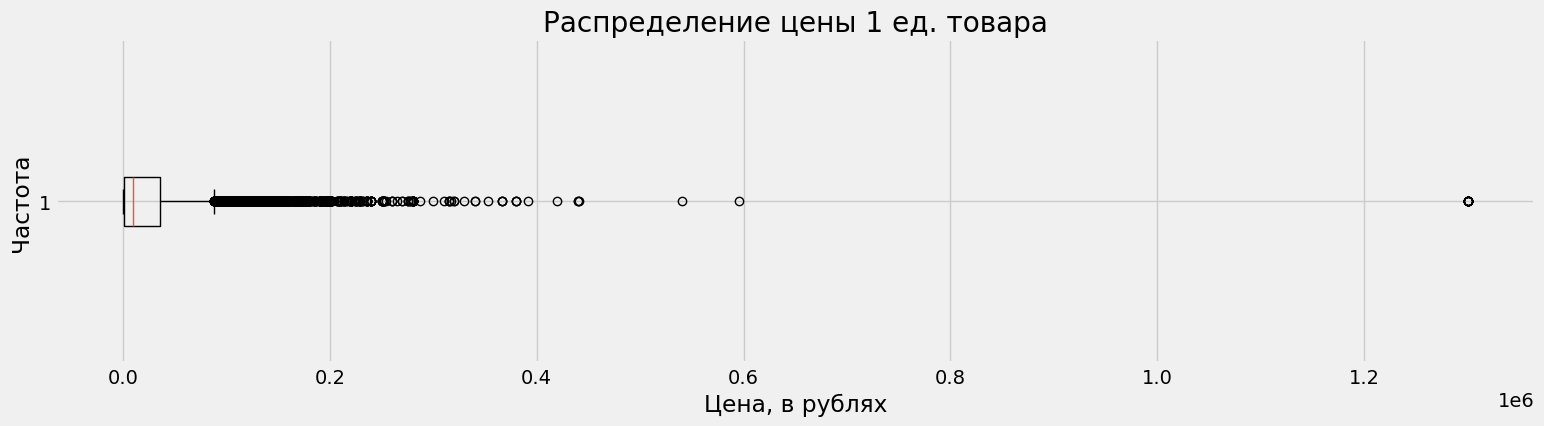

In [18]:
plt.figure(figsize=(17,4))
plt.boxplot(market['price'],vert = False);
plt.title ('Распределение цены 1 ед. товара');
plt.xlabel ('Цена, в рублях');
plt.ylabel ('Частота');

In [19]:
market['price'].describe()

count    4.818200e+04
mean     2.791895e+04
std      4.492339e+04
min      0.000000e+00
25%      1.204250e+03
50%      9.998000e+03
75%      3.599800e+04
max      1.299998e+06
Name: price, dtype: float64

In [20]:
market[market['price']==0.000000e+00]

,client_id,quantity,price,date
32019,1515915625520674208,1,0.0,2023-08-23 10:09:13+00:00
32020,1515915625520674208,1,0.0,2023-08-23 10:09:13+00:00


In [21]:
market[market['price']==1.299998e+06]

,client_id,quantity,price,date
28725,1515915625518981759,1,1299998.0,2022-11-03 15:05:30+00:00
28726,1515915625518981759,1,1299998.0,2022-11-03 15:14:08+00:00
28727,1515915625518981759,1,1299998.0,2022-11-03 15:15:50+00:00
28728,1515915625518981759,1,1299998.0,2022-11-03 15:19:33+00:00
28729,1515915625518981759,1,1299998.0,2022-11-03 15:23:29+00:00
28730,1515915625518981759,1,1299998.0,2022-11-03 15:42:01+00:00
28731,1515915625518981759,1,1299998.0,2022-11-03 16:06:50+00:00
28732,1515915625518981759,1,1299998.0,2022-11-03 16:10:16+00:00
28733,1515915625518981759,1,1299998.0,2022-11-03 17:03:13+00:00
28734,1515915625518981759,1,1299998.0,2022-11-03 18:06:15+00:00


In [22]:
market[market['price']==3.599800e+04]

,client_id,quantity,price,date
32,1515915625442799497,1,35998.0,2023-05-10 10:53:18+00:00
61,1515915625444717160,1,35998.0,2023-05-26 11:01:55+00:00
63,1515915625445587855,1,35998.0,2023-05-10 13:42:18+00:00
109,1515915625456888187,2,35998.0,2023-05-23 05:51:58+00:00
111,1515915625456888187,1,35998.0,2023-05-26 08:32:48+00:00
...,...,...,...,...
47959,1515915625574004578,1,35998.0,2023-04-10 14:17:18+00:00
47970,1515915625574084883,1,35998.0,2023-04-08 08:05:31+00:00
48049,1515915625574682759,1,35998.0,2023-04-24 09:57:07+00:00
48111,1515915625575221721,1,35998.0,2023-04-21 14:09:42+00:00


В среднем товары покупались по цене 27 918 руб. 
Есть клиент который совершил покупку на 0 рублей, можно смело удалить, т.к. не несет для нас никакой ценности. 

Максимальная цена -  1 299 998 руб. Думаю, стоит отдельно рассмотреть данного клиента и напомнить ему о предстоящих акциях в ноябре, т.к. последние и единственные покупки у него были в ноябре 2022 г, видимо связанные с ноябрьским распродажами 11.11.


In [23]:
market = market[market['price'] > 0]

**Динамика продаж за год и по месяцам**

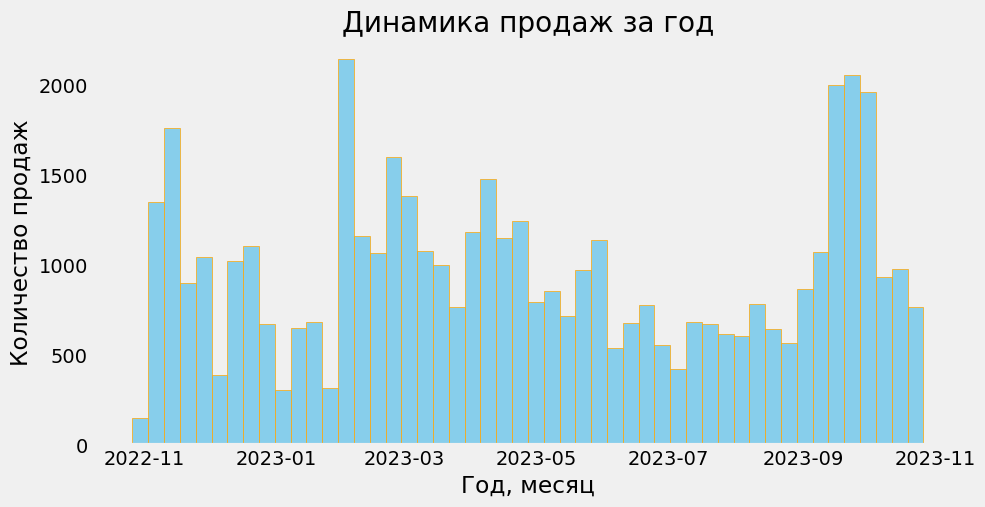

In [24]:
market['date'].hist(bins=50, figsize=(10,5), color='skyblue',edgecolor='orange', grid=False)
plt.title('Динамика продаж за год')
plt.xlabel('Год, месяц')
plt.ylabel('Количество продаж')
plt.show();

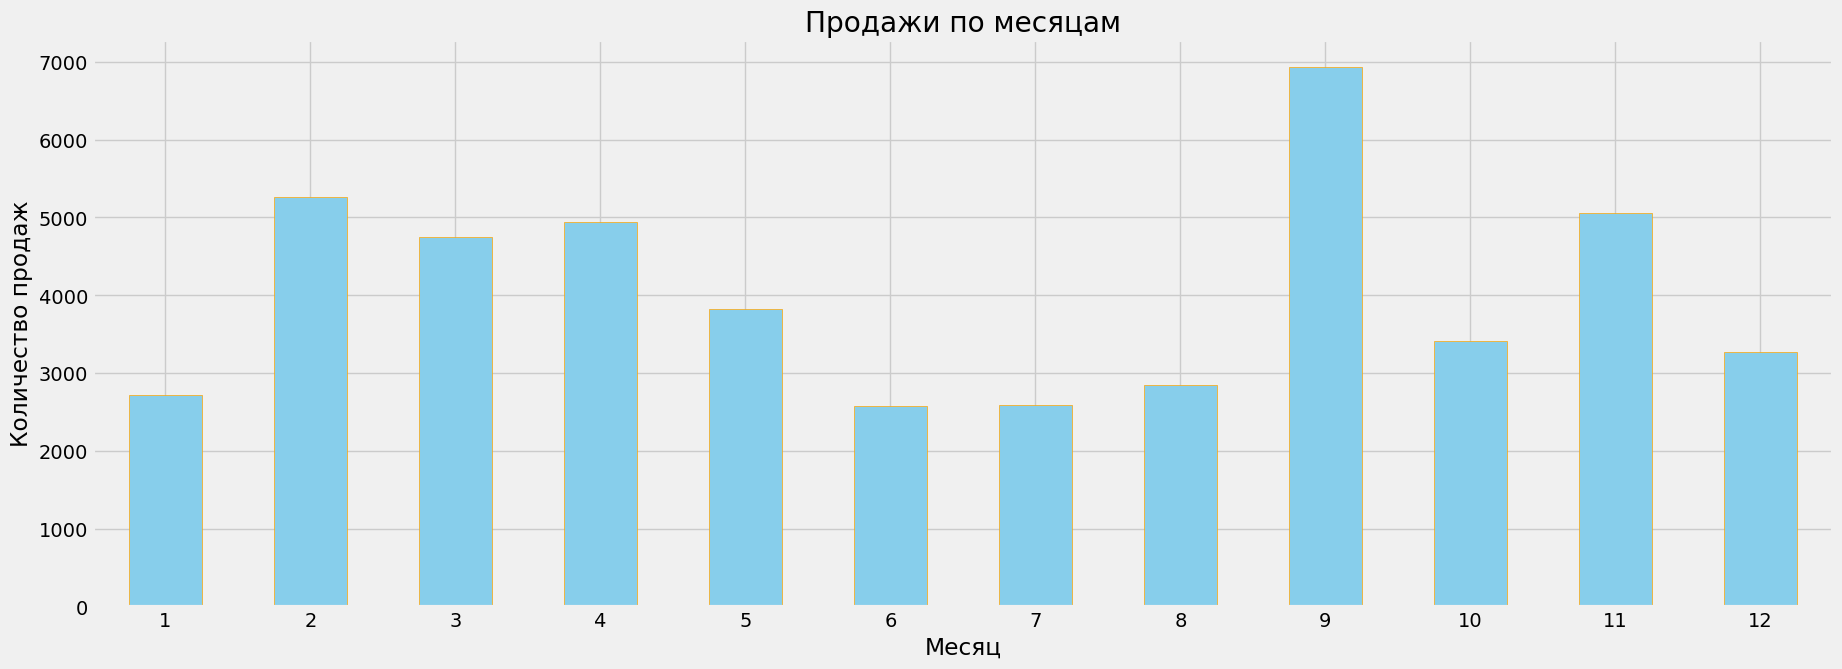

In [25]:
market['month'] = market['date'].dt.month
plt.figure(figsize=(20, 7))
market.groupby('month').size().plot(kind='bar', color='skyblue', edgecolor='orange')
plt.title('Продажи по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество продаж')
plt.xticks(rotation=0)
plt.show();

Больше всего покупок были совершено в сентябре, потом идет февраль и ноябрь. В летних месяцях прослеживается спад и стабильный спрос. В январе также идет спад покупок, связанный с постпраздничным периодом.

In [26]:
# пока удалим данный столбец
market = market.drop('month', axis=1)

**Количество товара в заказе**

In [27]:
market['quantity'].value_counts()

1     47913
2       148
3        55
4        18
5        11
10       10
7         7
6         6
50        4
8         3
27        1
9         1
23        1
20        1
30        1
Name: quantity, dtype: int64

Больше всего (47915) покупают по 1 позиции, по 2 позиции - 148 заказов. Также есть 4 заказа по 50 позиций, 10 заказов по 10 позиций. Можно рассмотреть их подробнее.

In [28]:
market[market['quantity']==50]

,client_id,quantity,price,date
31844,1515915625582703881,50,751.0,2023-08-31 11:49:16+00:00
31872,1515915625582703881,50,900.0,2023-08-31 13:01:09+00:00
31874,1515915625582703881,50,900.0,2023-08-31 13:03:03+00:00
31885,1515915625582703881,50,900.0,2023-08-31 15:14:55+00:00


Похоже на закупки к учебному году.

## 3. Обоснование решения и подготовка RFM признаков

После предварительно обзора данных выдвинем гипотезу о том, что на повторную покупку влияет частота посещения маркетплейса, количество купленных товаров, а также потраченная сумма.

Нам нужно ответить на вопрос: будет ли клиет совершать повторные покупки в нашем маркетплейсе с интервалом до 30 дней.   
У нас нет сведений о конкретных товарах и специфики данного маркетплейса.   

Перед нами стоит **задача бинарной классификации**. Воспользуемся возможностями машинного обучения и создадим прототип модели, которая поможет нашему маркетплейсу отслеживать динамику покупателькой активности и своевремнно принимать необходимые действия по удержанию клиентов. Метрика качества будет выбрана позднее, после изучения баланса классов в таргете.

Составим портрет нашего клиента, на основе имеющихся исторических данных, а также проведем RFM анализ и в качестве категориальной фичи будем использовать категорию клиента.

Далее создадим таргет. Для этого сначала сделаем группировку по клиенту и дате, далее отсортируем по клиенту и дате и найдем разницу в днях между текущей покупкой и следующей. Если эта разница больше 30 проставим класс 0, если меньше то 1.
Там где разница в днях будет равна 0 (т.е. было несколько покупок в один день), заполним пропуск "заглушкой' = '999'. Для обработки датасета напишем функцию.

После этого "отрежем" 30 последних дней из датасета, для проведения теста после обучения модели.   

In [29]:
def process_dataset(data):
    """
    Функция обработки датасета с клиентскими данными, включая:
    - Преобразование столбца 'date' к типу данных date
    - Группировка данных по 'client_id' и 'date', подсчет суммы 'quantity' и средней 'price'
    - Сортировка данных по 'client_id' и 'date'
    - Добавление столбца 'next_purchase_date' с датой следующей покупки для каждого клиента
    - Вычисление разницы в днях между покупками
    - Заполнение пропущенных значений в столбце 'days_diff' значением '999'
    - Создание целевой переменной 'target' на основе условия, что 'days_diff' > 30
    - Удаление столбца 'next_purchase_date', если он больше не нужен
    
    Параметры:
    data (pd.DataFrame): Датафрейм с исходными данными клиентов
    
    Возвращает:
    data (pd.DataFrame): Обработанный датафрейм с добавленной целевой переменной
    
    """
    
    #  переведем столбец к типу данных date
    data['date'] = pd.to_datetime(data['date']).dt.date
    
    # сруппируем по клиенту и дате, подсчитаем суммы 'quantity' и средней 'price'
    data = data.groupby(['client_id', 'date']).agg({'quantity': 'sum', 'price': 'mean'}).reset_index()
    
    # сортировка по 'client_id' и 'date'
    data = data.sort_values(by=['client_id', 'date'])
    
    # добавим столбец 'next_purchase_date' с датой следующей покупки для каждого клиента
    data['next_purchase_date'] = data.groupby('client_id')['date'].shift(-1)
    
    # вычислим разницу в днях между покупками
    data['days_diff'] = (data['next_purchase_date'] - data['date']).dt.days
    # заполним пропущенные значений в столбце next_purchase_days_diff заглушкой '999'
    data['days_diff'] = data['days_diff'].fillna(999)
    
    # создадим целевую переменную 'target'
    data['target'] = np.where(data['days_diff'] > 30, 0, 1)
    
    # удалим столбца 'next_purchase_date', если он больше не нужен
    data = data.drop(columns='next_purchase_date', axis=1)
    
    return data

# обработаем датасет
processed_market = process_dataset(market)
processed_market.head(10)

,client_id,date,quantity,price,days_diff,target
0,1515915625440099873,2023-07-16,1,31998.0,24.0,1
1,1515915625440099873,2023-08-09,1,1218.0,999.0,0
2,1515915625440939402,2023-01-30,1,75998.0,999.0,0
3,1515915625440944408,2023-03-01,1,882.0,62.0,0
4,1515915625440944408,2023-05-02,1,6298.0,50.0,0
5,1515915625440944408,2023-06-21,1,73998.0,999.0,0
6,1515915625440947454,2022-11-06,2,101.0,48.0,0
7,1515915625440947454,2022-12-24,2,2142.0,999.0,0
8,1515915625440952940,2022-11-11,1,479.0,999.0,0
9,1515915625440956290,2023-08-03,2,99999.0,999.0,0


In [30]:
# переводим столбца 'date' к типу данных date
processed_market['date'] = pd.to_datetime(processed_market['date'])

Перед созданием признаков для обучения модели, предварительно отделим выборку для теста, последние 30 дней.

In [31]:
# разделим на трейн и тест
train = processed_market[processed_market['date'] < '2023-09-26']
test = processed_market[processed_market['date'] >= '2023-09-26']

In [32]:
# посмотрим и проверим размеры
train.shape,test.shape

((21400, 6), (2525, 6))

Далее проведем **RFM-анализ** — метод анализа, позволяющий сегментировать клиентов по частоте и сумме покупок и выявлять тех, которые приносят больше денег.   

Аббревиатура RFM расшифровывается:   
Recency — давность (как давно пользователи что-то покупали);
Frequency — частота (как часто они покупают);
Monetary — деньги (общая сумма покупок).
По каждому из этих признаков мы выделим по три равные группы. 
Затем присваиваем каждой группе числовое обозначение от 1 до 3   
Давность последней покупки (Recency)   
Частота покупок (Frequency)   
Сумма покупки (Monetary)

Давность последней покупки (Recency): 1 - недавние клиенты; 2 - редкие; 3 - давние, возможно потерянные.      
Частота покупок (Frequency): 1 - частые; 2 - редкие нерегулярные; 3 - очень редкие.   
Сумма покупки (Monetary): 1 - большая; 2 - средняя;3 - маленькая.   


Анализ будет немного осложнен отсутствием специфики магазина.
Напишем функцию, которая будет обрабатывать датасет для RFM анализа.

In [33]:
# отсортируем по клиенту и дате
df = train.copy
df = train.sort_values(['client_id', 'date'])
df.head()

,client_id,date,quantity,price,days_diff,target
0,1515915625440099873,2023-07-16,1,31998.0,24.0,1
1,1515915625440099873,2023-08-09,1,1218.0,999.0,0
2,1515915625440939402,2023-01-30,1,75998.0,999.0,0
3,1515915625440944408,2023-03-01,1,882.0,62.0,0
4,1515915625440944408,2023-05-02,1,6298.0,50.0,0


In [34]:
# группировка по каждому клиенту и расчет метрик
df2 = df.groupby('client_id').agg(
    monetary_value = ('price', 'sum'),
    frequency = ('date', 'count'),
    last_purchase= ('date', 'last'),
    min_price = ('price', 'min'),
    max_price = ('price', 'max'),
    total_quantity = ('quantity', 'sum'),
).reset_index()
df2.head()

,client_id,monetary_value,frequency,last_purchase,min_price,max_price,total_quantity
0,1515915625440099873,33216.0,2,2023-08-09,1218.0,31998.0,2
1,1515915625440939402,75998.0,1,2023-01-30,75998.0,75998.0,1
2,1515915625440944408,81178.0,3,2023-06-21,882.0,73998.0,3
3,1515915625440947454,2243.0,2,2022-12-24,101.0,2142.0,4
4,1515915625440952940,479.0,1,2022-11-11,479.0,479.0,1


In [35]:
# переведем в формат даты
df['date'] = pd.to_datetime(df['date'])
df2['last_purchase'] = pd.to_datetime(df2['last_purchase'])

In [36]:
# рассчитаем количество дней прошедших с момента последней покупки до 25.09.2023
df2['days_since_last_purchase'] = (max(df['date']) - df2['last_purchase']).dt.days

In [37]:
df2.head()

,client_id,monetary_value,frequency,last_purchase,min_price,max_price,total_quantity,days_since_last_purchase
0,1515915625440099873,33216.0,2,2023-08-09,1218.0,31998.0,2,47
1,1515915625440939402,75998.0,1,2023-01-30,75998.0,75998.0,1,238
2,1515915625440944408,81178.0,3,2023-06-21,882.0,73998.0,3,96
3,1515915625440947454,2243.0,2,2022-12-24,101.0,2142.0,4,275
4,1515915625440952940,479.0,1,2022-11-11,479.0,479.0,1,318


In [38]:
df2[df2['days_since_last_purchase'] < 30].count()

client_id                   2545
monetary_value              2545
frequency                   2545
last_purchase               2545
min_price                   2545
max_price                   2545
total_quantity              2545
days_since_last_purchase    2545
dtype: int64

Основная сложность RFM-анализа — определить границы сегментов, потому что универсальных рекомендаций по этому поводу нет.
В данном исследовании для того, чтобы оценить распределение покупателей, были рассчитаны средние, медианы и перцентили.
Перцентили позволяют нарезать слоями массив данных и понять, на какие группы делятся элементы. Таким образом, покажут изменения с большей точностью, но спрячут выбросы. 
Для большей точности было сделано распределение по децилям и потом для сегментации клиентов были выбраны 0.15 и 0.9 децили.

In [39]:
quantiles = [round(el, 2) for el in np.arange(0.1, 1.1, 0.1)]

**Давность последней покупки (Recency)**

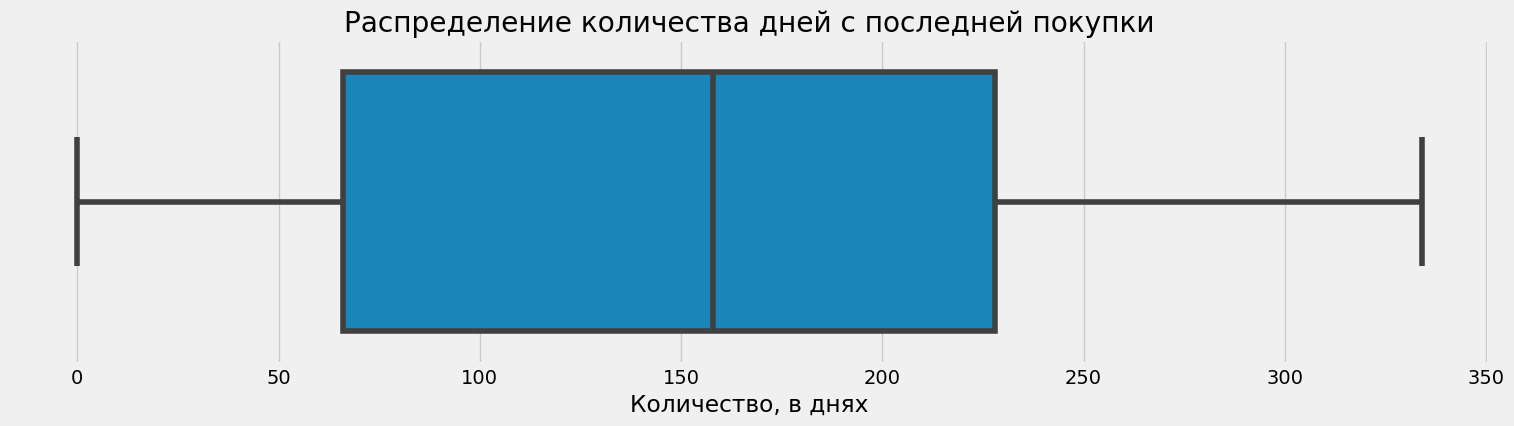

In [40]:
plt.figure(figsize=(17,4))
sns.boxplot(x=df2['days_since_last_purchase'])
plt.title('Распределение количества дней с последней покупки')
plt.xlabel('Количество, в днях')
plt.show()

In [41]:
df2['days_since_last_purchase'].describe()

count    16083.000000
mean       153.536778
std         98.317355
min          0.000000
25%         66.000000
50%        158.000000
75%        228.000000
max        334.000000
Name: days_since_last_purchase, dtype: float64

In [42]:
df2['days_since_last_purchase'].quantile(quantiles)

0.1     11.0
0.2     45.0
0.3     88.0
0.4    126.0
0.5    158.0
0.6    182.0
0.7    212.0
0.8    238.0
0.9    302.8
1.0    334.0
Name: days_since_last_purchase, dtype: float64

Из распределения по децилям видно, что только около 15 % клиентов - те, у кого последняя покупка была меньше 30 дней назад. Т.е.это либо постоянные клиенты либо новые, которые были недавно и маркетплейсу стоит уделить им внимание (рассылкой скидок и т.д), чтобы они пришли снова.  Это самая 'свежая' группа 1.

Медиана (158 дней) и среднее (153 дней). Т.е.40 % клиентов относим в среднюю категорию, кто не приходил от 1,5 месяцев более 5 месяцев. Это группа 2.

Оставшиеся 45 % это те, кто очень давно не приходил в маркетплейс более 180 дней (почти 6 месяцев) дней попадают в группу 3, потому что это либо в принципе редкие посетители (например, разовые), либо ушедшие к конкурентам. 

**Частота покупок (Frequency)**

In [43]:
df2['frequency'].describe()

count    16083.000000
mean         1.330598
std          1.211427
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         45.000000
Name: frequency, dtype: float64

In [44]:
df2['frequency'].quantile(quantiles)

0.1     1.0
0.2     1.0
0.3     1.0
0.4     1.0
0.5     1.0
0.6     1.0
0.7     1.0
0.8     1.0
0.9     2.0
1.0    45.0
Name: frequency, dtype: float64

Среднее количество покупок 1.3, медианное количество - 1. Можем предположить, что у маркетпейса много разовых покупателей, которых хорошо бы сделать постоянными лояльным клиентами.
Отдельно стоит рассмотреть клиентов, с частотой заказов более 10. Таких нашлось 43 человека. Для нашего маркетплейса это довольно потенциальные клиенты, с которыми необходимо провести индивидуальную работу.

In [45]:
df2[df2['frequency'] > 10].head(10)

,client_id,monetary_value,frequency,last_purchase,min_price,max_price,total_quantity,days_since_last_purchase
129,1515915625441885478,520885.812500,26,2023-09-16,10.000000,109998.000000,39,9
196,1515915625442705963,560661.312500,14,2023-06-20,5998.000000,86998.000000,23,97
339,1515915625446481060,626658.750000,11,2023-09-25,6798.000000,124198.000000,27,0
357,1515915625446805060,53438.832031,11,2023-09-25,918.000000,23398.000000,21,0
363,1515915625446969042,306786.250000,12,2023-06-08,619.500000,70798.000000,24,109
395,1515915625448676587,597888.500000,17,2023-09-24,6085.333496,92864.664062,55,1
597,1515915625457971346,158510.156250,11,2023-09-18,1570.400024,36998.000000,38,7
894,1515915625474267367,178258.000000,13,2023-09-04,31.000000,89998.000000,24,21
1413,1515915625496098445,425262.718750,20,2023-09-21,7.000000,71698.000000,35,4
1755,1515915625498293494,304730.000000,16,2023-09-14,3198.000000,38183.000000,58,11


Данные клиенты совершали больше всего покупок и на большие суммы. Часть из них были недавно, часть давно. Тем кто был давно нужно реактивировать его лояльность → предложить ему в подарок то, что он покупал раньше чаще всего.
Тем кто был недавно, надоедать рассылками не стоит, следует отслеживать дальшейшую покупательскую активность.

**Сумма покупки (Monetary)**


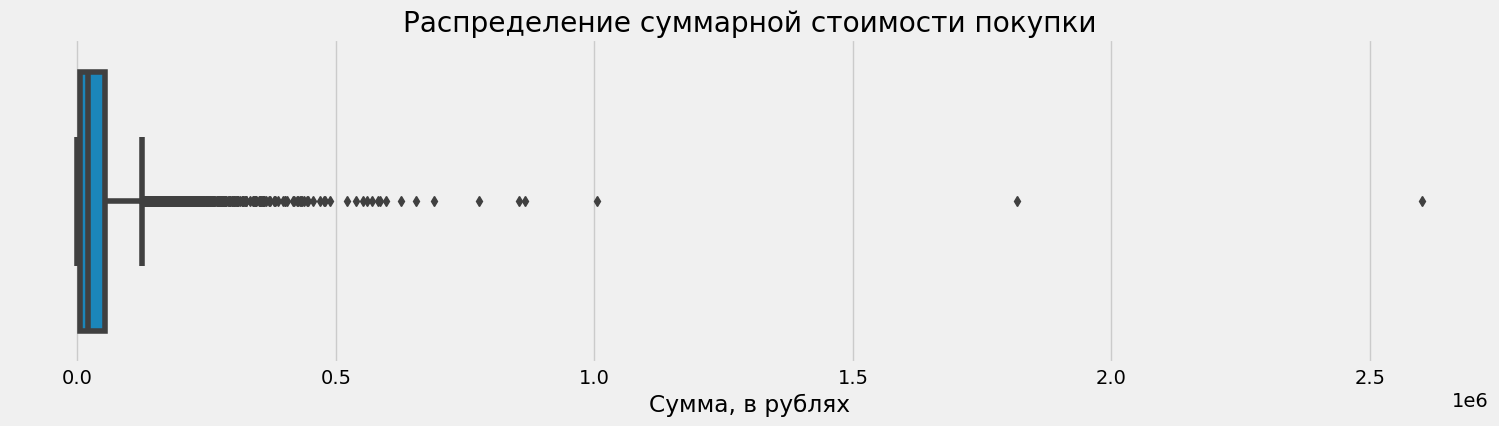

In [46]:
plt.figure(figsize=(17,4))
sns.boxplot(x=df2['monetary_value'])
plt.title('Распределение cуммарной стоимости покупки')
plt.xlabel('Сумма, в рублях')
plt.show()

In [47]:
df2['monetary_value'].describe()

count    1.608300e+04
mean     4.000325e+04
std      6.000286e+04
min      2.000000e+00
25%      5.402000e+03
50%      1.999800e+04
75%      5.336467e+04
max      2.599996e+06
Name: monetary_value, dtype: float64

In [48]:
df2['monetary_value'].quantile(quantiles)

0.1    9.303000e+02
0.2    3.398000e+03
0.3    7.886528e+03
0.4    1.332380e+04
0.5    1.999800e+04
0.6    2.999800e+04
0.7    4.339680e+04
0.8    6.453112e+04
0.9    1.071130e+05
1.0    2.599996e+06
Name: monetary_value, dtype: float64

Среднее – самый популярный статистический показатель, но чувствительный к выбросам, которые смещают среднее значение и могут ввести в заблуждение. Медиана показывает центральное значение в выборке. 

В нашем случае средняя сумма покупок  40 003 руб., медианная сумма 19 998 руб. Значения сильно отличаются, и мы можем предположить наличие выбросов (отдельные клиенты покупали на очень большие суммы).

Категория 1. Из распределения мы видим, что это 30% это лояльные покупатели, которые покупали на сумму 64 531 р и более.   
Категория 2 - основная масса клиентов (40%), которая покупает на сумму от 13 323- 64 531 руб.   
В эти границы попадает медиана (19 998 р.) и среднее (40 003 р.)

Категория 3 - оставшийся 30% сегмент клиентов, которые покупают на небольшие суммы (до 13 323 руб.)   

Для проведения сегментации клиентов возьмем пороги 0,15 и 0,9 перцентили, т.к. в эти значения попадет 30 дневный период с даты последней покупки, что критически важно для нашей задачи.

In [49]:
quantiles = [0.15, 0.9]

In [50]:
df2['days_since_last_purchase'].quantile(quantiles)

0.15     25.0
0.90    302.8
Name: days_since_last_purchase, dtype: float64

In [51]:
df2['frequency'].quantile(quantiles)

0.15    1.0
0.90    2.0
Name: frequency, dtype: float64

In [52]:
df2['monetary_value'].quantile(quantiles)

0.15      1998.0
0.90    107113.0
Name: monetary_value, dtype: float64

Напишем функцию `set_score`, которая вычисляет оценку (score) на основе переданных параметров `val`, `var`, `perc_15` и `perc_90`. Она используется для назначения оценок (от 1 до 3) в зависимости от значения `val` в соответствии с заданными квантилями и условиями.

In [53]:
def set_score(val, var, perc_15, perc_90):
    """
    Функция для установления оценки (score) на основе значения, переменной и пороговых значений.

    Параметры:
    val (float): Значение, для которого устанавливается оценка.
    var (str): Переменная, используемая для установления оценки. Возможные значения: 'R' или другие.
    perc_15 (float): Пороговое значение для оценки 15-ого процентиля.
    perc_90 (float): Пороговое значение для оценки 90-ого процентиля.

    Возвращает:
    int: Оценка (score) в соответствии с заданными условиями:
         - Если значение меньше 15-ого процентиля: 3 если var != 'R', иначе 1.
         - Если значение меньше 90-ого процентиля: 2.
         - Во всех остальных случаях: 1 если var != 'R', иначе 3.
         
    """
    if val < perc_15:
     return 3 if var != 'R' else 1
    elif val < perc_90:
     return 2
    else:
     return 1 if var != 'R' else 3


In [54]:
recency_quantiles = df2['days_since_last_purchase'].quantile(quantiles)
df2['R'] = df2['days_since_last_purchase'].apply(set_score, args=('R', recency_quantiles.iloc[0], recency_quantiles.iloc[1]))

frequency_quantiles = df2['frequency'].quantile(quantiles)
df2['F'] = df2['frequency'].apply(set_score, args=('F', frequency_quantiles.iloc[0], frequency_quantiles.iloc[1]))

monetary_quantiles = df2['monetary_value'].quantile(quantiles)
df2['M'] = df2['monetary_value'].apply(set_score, args=('M', monetary_quantiles.iloc[0], monetary_quantiles.iloc[1]))

In [55]:
# проверим на любом клиенте
df2[df2['client_id']==1515915625440988920]

,client_id,monetary_value,frequency,last_purchase,min_price,max_price,total_quantity,days_since_last_purchase,R,F,M
15,1515915625440988920,23365.833984,9,2023-07-26,11.0,9598.0,20,61,2,1,2


In [56]:
df2['RFM'] = df2.apply(lambda row: f"{row['R']}{row['F']}{row['M']}", axis=1)

In [57]:
df2.head()

,client_id,monetary_value,frequency,last_purchase,min_price,max_price,total_quantity,days_since_last_purchase,R,F,M,RFM
0,1515915625440099873,33216.0,2,2023-08-09,1218.0,31998.0,2,47,2,1,2,212
1,1515915625440939402,75998.0,1,2023-01-30,75998.0,75998.0,1,238,2,2,2,222
2,1515915625440944408,81178.0,3,2023-06-21,882.0,73998.0,3,96,2,1,2,212
3,1515915625440947454,2243.0,2,2022-12-24,101.0,2142.0,4,275,2,1,2,212
4,1515915625440952940,479.0,1,2022-11-11,479.0,479.0,1,318,3,2,3,323


**Создадим список для работы с клиентами по персонализированной рассылке**

In [58]:
df3 = df2.groupby('RFM')['RFM'].agg({'count'}).reset_index()
df3

,RFM,count
0,111,140
1,112,431
2,113,32
3,121,59
4,122,1339
5,123,393
6,211,539
7,212,1540
8,213,92
9,221,776


Мы получили категорийную фичу, основанную на RFM анализе. Далее для создания дополнительных признаков объединим наш датасет с фичами после RFM анализа и исходный датасет market.

**Вывод по RFM анализу** 

После разделения людей на группы получили 27 сегментов. 
Здесь стоит более подробно остановиться на дальнейшем исследовании этих групп, но мы пока этого делать не будем, т.к. перед нами стоит другая задача. Приведем лишь некоторые примеры как можно работать с результатами данного анализа.

Анализ помогает определить клиентов, которые покупают часто и на большие суммы, клиентов, которые регулярно возвращаются за небольшими покупками, и клиентов, которые давно ничего не покупали.
Таргетирование рассылок на определенные группы клиентов дает гораздо большую конверсию рекламы, нежели одинаковая не персонализированная реклама.

Мы видим самую большую группу потенциальных клиентов "222", которых можно попробовать перевести в лояльные.

❎ Например, клиент «333» покупал давно, один раз и на маленькую сумму. И скорее всего, нам не стоит за него бороться.

✅Но при этом клиентов «313», «312», «311» обязательно нужно попытаться вернуть - это наши уходящие постоянные клиенты с разным чеком. Отправляем им реактивационные письма, запрашиваем обратную связь, предлагаем бонусы, программы лояльности.

🔥Или пользователь «111»: покупает часто, на большую сумму и последняя покупка была недавно. Это наши лучшие клиенты. Таким клиентам следует уделять особое внимание, например, предлагать им эксклюзивные продукты или услуги, бонусы и скидки.

Также можно отдельно посмотреть и поработать с клиентами, которые покупали менее 30 дней назад от 25.09.2023.
Создали список для работы с клиентами по персонализированной рассылке.

Далее объединим результаты RFM датасета с нашим исходным для дальнейшей подготовки к обучению модели.

In [59]:
df4 = train.merge(
    df2, 
    left_on= 'client_id', 
    right_on='client_id', 
    how='left'
)
df4.head()

,client_id,date,quantity,price,days_diff,target,monetary_value,frequency,last_purchase,min_price,max_price,total_quantity,days_since_last_purchase,R,F,M,RFM
0,1515915625440099873,2023-07-16,1,31998.0,24.0,1,33216.0,2,2023-08-09,1218.0,31998.0,2,47,2,1,2,212
1,1515915625440099873,2023-08-09,1,1218.0,999.0,0,33216.0,2,2023-08-09,1218.0,31998.0,2,47,2,1,2,212
2,1515915625440939402,2023-01-30,1,75998.0,999.0,0,75998.0,1,2023-01-30,75998.0,75998.0,1,238,2,2,2,222
3,1515915625440944408,2023-03-01,1,882.0,62.0,0,81178.0,3,2023-06-21,882.0,73998.0,3,96,2,1,2,212
4,1515915625440944408,2023-05-02,1,6298.0,50.0,0,81178.0,3,2023-06-21,882.0,73998.0,3,96,2,1,2,212


**Подготовка данных для тестовой выборки**

Сделаем по аналогии с трейном.


In [60]:
test = test.sort_values(['client_id', 'date'])
test.head()    

,client_id,date,quantity,price,days_diff,target
20,1515915625440981562,2023-10-01,1,25798.0,999.0,0
41,1515915625440995965,2023-10-11,1,14998.0,999.0,0
51,1515915625440996406,2023-09-28,1,6118.0,999.0,0
54,1515915625441001906,2023-10-03,1,2.0,999.0,0
57,1515915625441007350,2023-09-28,1,79998.0,1.0,1


In [61]:
df2_test = test.groupby('client_id').agg(
        monetary_value=('price', 'sum'),
        frequency=('date', 'count'),
        last_purchase=('date', 'last'),
        min_price = ('price', 'min'),
        max_price = ('price', 'max'),
        total_quantity = ('quantity', 'sum'),
        ).reset_index()
    
df2_test.head()

,client_id,monetary_value,frequency,last_purchase,min_price,max_price,total_quantity
0,1515915625440981562,25798.0,1,2023-10-01,25798.0,25798.0,1
1,1515915625440995965,14998.0,1,2023-10-11,14998.0,14998.0,1
2,1515915625440996406,6118.0,1,2023-09-28,6118.0,6118.0,1
3,1515915625441001906,2.0,1,2023-10-03,2.0,2.0,1
4,1515915625441007350,87996.0,2,2023-09-29,7998.0,79998.0,4


In [62]:
test['date'] = pd.to_datetime(test['date'])
df2_test['last_purchase'] = pd.to_datetime(df2_test['last_purchase'])
df2_test['days_since_last_purchase'] = (max(test['date']) - df2_test['last_purchase']).dt.days
    

In [63]:
recency_quantile = df2_test['days_since_last_purchase'].quantile(quantiles)
df2_test['R'] = df2_test['days_since_last_purchase'].apply(set_score, args=('R', recency_quantile.iloc[0], recency_quantile.iloc[1]))

frequency_quantile = df2_test['frequency'].quantile(quantiles)
df2_test['F'] = df2_test['frequency'].apply(set_score, args=('F', frequency_quantile.iloc[0], frequency_quantile.iloc[1]))

monetary_quantile = df2_test['monetary_value'].quantile(quantiles)
df2_test['M'] = df2_test['monetary_value'].apply(set_score, args=('M', monetary_quantile.iloc[0], monetary_quantile.iloc[1]))

In [64]:
df2_test['RFM'] = df2_test.apply(lambda row: f"{row['R']}{row['F']}{row['M']}", axis=1)

In [65]:
df4_test = test.merge(
    df2_test, 
    left_on= 'client_id', 
    right_on='client_id', 
    how='left'
)
df4_test.head()

,client_id,date,quantity,price,days_diff,target,monetary_value,frequency,last_purchase,min_price,max_price,total_quantity,days_since_last_purchase,R,F,M,RFM
0,1515915625440981562,2023-10-01,1,25798.0,999.0,0,25798.0,1,2023-10-01,25798.0,25798.0,1,25,2,2,2,222
1,1515915625440995965,2023-10-11,1,14998.0,999.0,0,14998.0,1,2023-10-11,14998.0,14998.0,1,15,2,2,2,222
2,1515915625440996406,2023-09-28,1,6118.0,999.0,0,6118.0,1,2023-09-28,6118.0,6118.0,1,28,2,2,2,222
3,1515915625441001906,2023-10-03,1,2.0,999.0,0,2.0,1,2023-10-03,2.0,2.0,1,23,2,2,3,223
4,1515915625441007350,2023-09-28,1,79998.0,1.0,1,87996.0,2,2023-09-29,7998.0,79998.0,4,27,2,1,1,211


In [66]:
# удалим неинформативные столбцы теста
df4_test = df4_test.drop(['last_purchase','R','F','M'], axis=1)

In [67]:
# удалим неинформативные столбцы трейна
df4 = df4.drop(['last_purchase','R','F','M'], axis=1)

## 4.Выбор метрики, подготовка финального набора признаков

In [68]:
df4['target'].value_counts()

0    17851
1     3549
Name: target, dtype: int64

Мы наблюдаем довольно сильный дисбаланс классов. Также перед нами стоит задача узнать совершит ли клиент покупку или нет, т.е. нам нужно довольно точно находить именно тех клиентов, кто сделает приобретение. Поэтому будем использовать F1-меру в качестве метрики, поскольку она учитывает как полноту (recall), так и точность (precision) одновременно. Это полезно, когда оба эти аспекта критически важны для вашей задачи, и мы хотим гарантировать, что модель не только часто правильно идентифицирует положительный класс (высокая полнота), но и то, что многие из её положительных предсказаний действительно верны (высокая точность).

Далее напишем функци, которые создают дополнитеьные признаки для обучения модели

In [69]:
def add_calendar_features(df):
    """
    Функция извлекает из даты и добавляет в датафрейм календарные фичи: день (число), 
    день недели, номер недели, месяц, год
    
    """
    df['date'] = pd.to_datetime(df['date']).dt.normalize()
    # столбец 'dow' (day of week) и заполним его числовым значением дня недели (0-Понедельник, 6-Воскресенье)
    df['dow'] = df['date'].dt.dayofweek
    # столбец 'day' и заполним его числом дня в месяце (1-31)
    df['day'] = df['date'].dt.day
    # столбец 'week' и заполним его значением номера недели в году
    df['week'] = df['date'].dt.isocalendar().week.astype('int32')
    # столбец 'month' и заполняет его числовым значением месяца (1-12)
    df['month'] = df['date'].dt.month

    # OHE code month
    months = {1: 'jan', 2: 'feb', 3: 'mar', 4: 'apr', 5: 'may', 6: 'jun',
            7: 'jul', 8: 'aug', 9: 'sep', 10: 'oct', 11: 'nov', 12: 'dec'}
    for month in months:
        df[months[month]] = np.where((df['month'] == month), 1, 0)

    return df

In [70]:
df4 = add_calendar_features(df4)
df4_test = add_calendar_features(df4_test)

In [71]:
def add_daysoff(df):
    """
    Функция загружает файлы производственных календарей, обрабатывает их и проставляет 
    метку 1 для всех выходных и праздничных дней. Эта категория шире суббот и воскресений
    (что мы ранее извлекли из даты), т.к. включает дополнительно государственные праздники
    и нерабочие дни, объявленные указами президента
    Кроме того, функция создает столбец "рабочий час", отмечая единицами часы, являющиеся
    рабочими по производственному календарю с учетом коротких дней перед праздниками
    
    """
    # read and preprocess tables with Russian production calendars
    c22 = pd.read_csv('calendar2022.csv')
    c23 = pd.read_csv('calendar2023.csv')

    def get_daysoff(df, year):
        """
        Функция принимает датафрейм производственного календаря и возвращает список
        всех выходных дней в соответствующем году
        
        """
        months = {'Январь': '01', 'Февраль': '02', 'Март': '03', 'Апрель': '04', 'Май': '05', 'Июнь': '06',
        'Июль': '07', 'Август': '08', 'Сентябрь': '09', 'Октябрь': '10', 'Ноябрь': '11', 'Декабрь': '12'}
        
        yearly_daysoff = []
        yearly_short = []
        for month in months:
            #filter out days with *. these are working short days before a holiday
            daysoff = [day for day in df[month].item().split(',') if '*' not in day]            
            daysoff = [day if len(day) > 1 else '0'+day for day in daysoff]

            #make a separate list of short working days (prior to a holiday)
            short_days = [day for day in df[month].item().split(',') if '*' in day]
            short_days = [day if len(day) > 1 else '0'+day for day in short_days]

            #format as proper dates
            daysoff = [(year + '-' + months[month] + '-' + day) for day in daysoff]
            yearly_daysoff.extend(daysoff)
            short_days = [(year + '-' + months[month] + '-' + day) for day in short_days]
            yearly_short.extend(short_days)

        return yearly_daysoff, yearly_short

    # get days off for 2 years
    all_daysoff = []
    all_short = []
    years = {'2022': c22, '2023': c23}
    for year in years:
        all_daysoff.extend(get_daysoff(df=years[year], year=year)[0])
        all_short.extend(get_daysoff(df=years[year], year=year)[1])

    # добавим выходные и предпраздничные дни
    df['dayoff'] = np.where(df['date'].astype('str').isin(all_daysoff), 1, 0)
    df['working_short'] = np.where(df['date'].astype('str').isin(all_short), 1, 0)

    
    return df    

In [72]:
def add_school_vacations(df):
    """
    Функция отмечает единицами дни школьных каникул и нулями - все остальные дни
    
    """
    vacs = pd.read_csv('holidays.csv')
    vacs = vacs.rename(columns={'Дата': 'date', 'Каникулы': 'school_vac'})
    vacs['date'] = pd.to_datetime(vacs['date']).dt.normalize()
    df = df.merge(vacs, on='date', how='left')
    return df

In [73]:
df4 = add_daysoff(df4)
df4 = add_school_vacations(df4)

In [74]:
df4_test = add_daysoff(df4_test)
df4_test = add_school_vacations(df4_test)

In [75]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21400 entries, 0 to 21399
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   client_id                 21400 non-null  int64         
 1   date                      21400 non-null  datetime64[ns]
 2   quantity                  21400 non-null  int64         
 3   price                     21400 non-null  float32       
 4   days_diff                 21400 non-null  float64       
 5   target                    21400 non-null  int32         
 6   monetary_value            21400 non-null  float32       
 7   frequency                 21400 non-null  int64         
 8   min_price                 21400 non-null  float32       
 9   max_price                 21400 non-null  float32       
 10  total_quantity            21400 non-null  int64         
 11  days_since_last_purchase  21400 non-null  int64         
 12  RFM               

In [76]:
# удалим неинформативные столбцы из трейна
df4 = df4.drop(['client_id','date','days_diff','jan','oct',
               'dec','working_short'], axis=1)

In [77]:
# удалим неинформативные столбцы из теста
df4_test = df4_test.drop(['client_id','date','days_diff','jan','oct',
               'dec','working_short'], axis=1)

In [78]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21400 entries, 0 to 21399
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   quantity                  21400 non-null  int64  
 1   price                     21400 non-null  float32
 2   target                    21400 non-null  int32  
 3   monetary_value            21400 non-null  float32
 4   frequency                 21400 non-null  int64  
 5   min_price                 21400 non-null  float32
 6   max_price                 21400 non-null  float32
 7   total_quantity            21400 non-null  int64  
 8   days_since_last_purchase  21400 non-null  int64  
 9   RFM                       21400 non-null  object 
 10  dow                       21400 non-null  int64  
 11  day                       21400 non-null  int64  
 12  week                      21400 non-null  int32  
 13  month                     21400 non-null  int64  
 14  feb   

**Посмотрим матрицу корреляции числовых признаков**

In [79]:
df4.corr(numeric_only = True)

,quantity,price,target,monetary_value,frequency,min_price,max_price,total_quantity,days_since_last_purchase,dow,...,mar,apr,may,jun,jul,aug,sep,nov,dayoff,school_vac
quantity,1.000000,-0.029596,0.086289,0.066745,0.099677,-0.037022,0.000087,0.324001,-0.003792,0.008167,...,0.000196,-0.022396,-0.006642,-0.006247,-0.015020,0.008653,-0.007933,0.008492,0.007844,-0.000043
price,-0.029596,1.000000,-0.028483,0.366298,-0.045179,0.883883,0.842364,-0.033706,0.060388,-0.020336,...,0.046181,0.015305,0.051241,0.032762,-0.001638,-0.045939,-0.074857,-0.024327,-0.013543,-0.001128
target,0.086289,-0.028483,1.000000,0.338014,0.455551,-0.148022,0.133345,0.330096,-0.150763,-0.022262,...,0.014105,-0.011107,-0.027822,-0.028153,-0.030502,-0.014610,0.049801,-0.008013,-0.025198,-0.038362
monetary_value,0.066745,0.366298,0.338014,1.000000,0.783092,0.213525,0.575238,0.609463,-0.170900,-0.019840,...,0.023210,0.010262,0.013709,0.004385,-0.012510,-0.027116,-0.034024,-0.012809,-0.017456,-0.015895
frequency,0.099677,-0.045179,0.455551,0.783092,1.000000,-0.174126,0.196032,0.808969,-0.260944,-0.016120,...,0.010486,0.000618,-0.010889,-0.014101,-0.011594,-0.005023,-0.006104,-0.004693,-0.019345,-0.017989
min_price,-0.037022,0.883883,-0.148022,0.213525,-0.174126,1.000000,0.724154,-0.115288,0.123358,-0.018707,...,0.034782,0.012800,0.056255,0.032041,0.000731,-0.035517,-0.065311,-0.019399,-0.012451,0.007379
max_price,0.000087,0.842364,0.133345,0.575238,0.196032,0.724154,1.000000,0.146202,-0.045083,-0.025989,...,0.045663,0.021877,0.051209,0.022715,-0.004186,-0.048393,-0.070075,-0.032084,-0.019531,-0.013431
total_quantity,0.324001,-0.033706,0.330096,0.609463,0.808969,-0.115288,0.146202,1.000000,-0.172615,-0.014160,...,0.001796,-0.011378,-0.005620,0.001071,-0.012703,0.007429,-0.006805,0.003176,-0.015153,0.000524
days_since_last_purchase,-0.003792,0.060388,-0.150763,-0.170900,-0.260944,0.123358,-0.045083,-0.172615,1.000000,0.037253,...,0.103161,0.013756,-0.070803,-0.129546,-0.208723,-0.289591,-0.521439,0.460228,0.052573,-0.246683
dow,0.008167,-0.020336,-0.022262,-0.019840,-0.016120,-0.018707,-0.025989,-0.014160,0.037253,1.000000,...,-0.072050,0.015982,-0.072073,-0.037726,0.033001,-0.052980,0.051917,0.080461,0.684564,-0.012686


Получили 23 признака для обучения модели. Данные признаки в процессе экспериментов добавлялись последовательно и изучалось изменение метрики. Те признаки, которые не вносили никакого вклада были удалены.

Провели проверку на мультиколлинеарность.

В качестве основной модели будет использоваться CatBoostClassifier, без подбора гиперпараметров и кросс-валидации. 
Тестирование будет проводиться на тестовой выборке, которую мы подготовили заранее и модель ее не видела. Данная модель отлично справляется с табличными признаками.

## 5. Обучение модели

In [80]:
# cоздадим переменные для признаков и целевого признака
X_train = df4.drop('target', axis=1)
y_train = df4['target']

In [81]:
y_train.value_counts()

0    17851
1     3549
Name: target, dtype: int64

In [82]:
# cоздадим переменные для признаков и целевого признака
X_test = df4_test.drop('target', axis=1)
y_test = df4_test['target']

In [83]:
y_test.value_counts()

0    2210
1     315
Name: target, dtype: int64

In [84]:
# выведем на экран размеры таблиц, которые хранятся в 2-х переменных
X_train.shape,y_train.shape

((21400, 24), (21400,))

**Проверка на адекватность**

In [85]:
dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(X_train,y_train)
dummy_model.score(X_train,y_train)

0.1658411214953271

Получили, что константная модель в 16 % случаев будет предсказывать класс 1, что соответсвует распределению классов в таргете.

In [86]:
#численные признаки
num_cols = X_train.select_dtypes(exclude='object').columns.to_list()
num_cols

['quantity',
 'price',
 'monetary_value',
 'frequency',
 'min_price',
 'max_price',
 'total_quantity',
 'days_since_last_purchase',
 'dow',
 'day',
 'week',
 'month',
 'feb',
 'mar',
 'apr',
 'may',
 'jun',
 'jul',
 'aug',
 'sep',
 'nov',
 'dayoff',
 'school_vac']

In [87]:
# создадим переменную с категориальными признаками для передачи в модель
cat_features = X_train.select_dtypes(include='object').columns.to_list()
cat_features

['RFM']

In [88]:
#численные признаки тест
num_cols_test = X_test.select_dtypes(exclude='object').columns.to_list()
num_cols

['quantity',
 'price',
 'monetary_value',
 'frequency',
 'min_price',
 'max_price',
 'total_quantity',
 'days_since_last_purchase',
 'dow',
 'day',
 'week',
 'month',
 'feb',
 'mar',
 'apr',
 'may',
 'jun',
 'jul',
 'aug',
 'sep',
 'nov',
 'dayoff',
 'school_vac']

In [89]:
# категориальные признаки тест
cat_features_test = X_test.select_dtypes(include='object').columns.to_list()
cat_features

['RFM']

In [90]:
# Инициализируем модель 
cb = CatBoostClassifier(loss_function='Logloss',
                        random_state=RANDOM_STATE,
                        eval_metric='AUC',class_weights=[1, 2]
                        )

# Создаем train_pool для обучения
train_pool = Pool(X_train, y_train, cat_features=cat_features)

In [91]:
%%time
cb.fit(train_pool,verbose=False)

CPU times: total: 1min 13s
Wall time: 39.9 s


In [92]:
# Вычисление F1 метрики
predictions = cb.predict(X_train)
f1_score_cb = f1_score(y_train, predictions)
print(f'F1 для CatBoostClassifier без кросс-валидации: {f1_score_cb}')

F1 для CatBoostClassifier без кросс-валидации: 0.817867656469986


**Промежуточные метрики в ходе экспериментов при обучении модели:**

1. F1 для CatBoostClassifier без кросс-валидации: 0.6165236412586236 (только на признаках RFM）   
При этом на тесте: 
Accuracy: 0.8899009900990099
Полнота: 0.17142857142857143
Точность: 0.7605633802816901
F1-мера: 0.2797927461139897
AUC-ROC:0.9598714357537887
            
2. При добавлении календарных фичей метрика заметно выросла (фичи week и day сработали)   
F1 для CatBoostClassifier без кросс-валидации: 0.7931912185809735
При этом на тесте: 
Accuracy: 0.8855445544554456
Полнота: 0.09206349206349207
Точность: 0.90625
F1-мера: 0.1671469740634006
AUC-ROC:0.9647719600660777

3. F1 для CatBoostClassifier без кросс-валидации: 0.6479201331114808 (на признаках RFM+min.max/price)   
Accuracy: 0.8934653465346535
Полнота: 0.20317460317460317
Точность: 0.7804878048780488
F1-мера: 0.3224181360201511
AUC-ROC:0.9585857932916757
4. F1 для CatBoostClassifier без кросс-валидации: 0.7853822728001282 (с добавлением каникул)   
Accuracy: 0.8871287128712871
Полнота: 0.10793650793650794
Точность: 0.8947368421052632
F1-мера: 0.1926345609065156
AUC-ROC:0.9642246642246641
5. F1 для CatBoostClassifier без кросс-валидации: 0.7981505102040817    
Accuracy: 0.8867326732673267
Полнота: 0.10476190476190476
Точность: 0.8918918918918919
F1-мера: 0.1875
AUC-ROC:0.9652617970265029
6. F1 для CatBoostClassifier без кросс-валидации: 0.8265635074145713 (поставила метрику AUC в модели и приоритет  1 класса)   
Accuracy: 0.8942574257425743
Полнота: 0.23809523809523808
Точность: 0.7352941176470589
F1-мера: 0.3597122302158273
AUC-ROC:0.9657947281476693
6. F1 для CatBoostClassifier без кросс-валидации: 0.8262837925236062 (убрала из признаков январь, декабрь, октябрь и короткий час перед выходным), полнота выросла   
Accuracy: 0.8982178217821782
Полнота: 0.273015873015873
Точность: 0.7543859649122807
F1-мера: 0.40093240093240085
AUC-ROC:0.9601896143072614


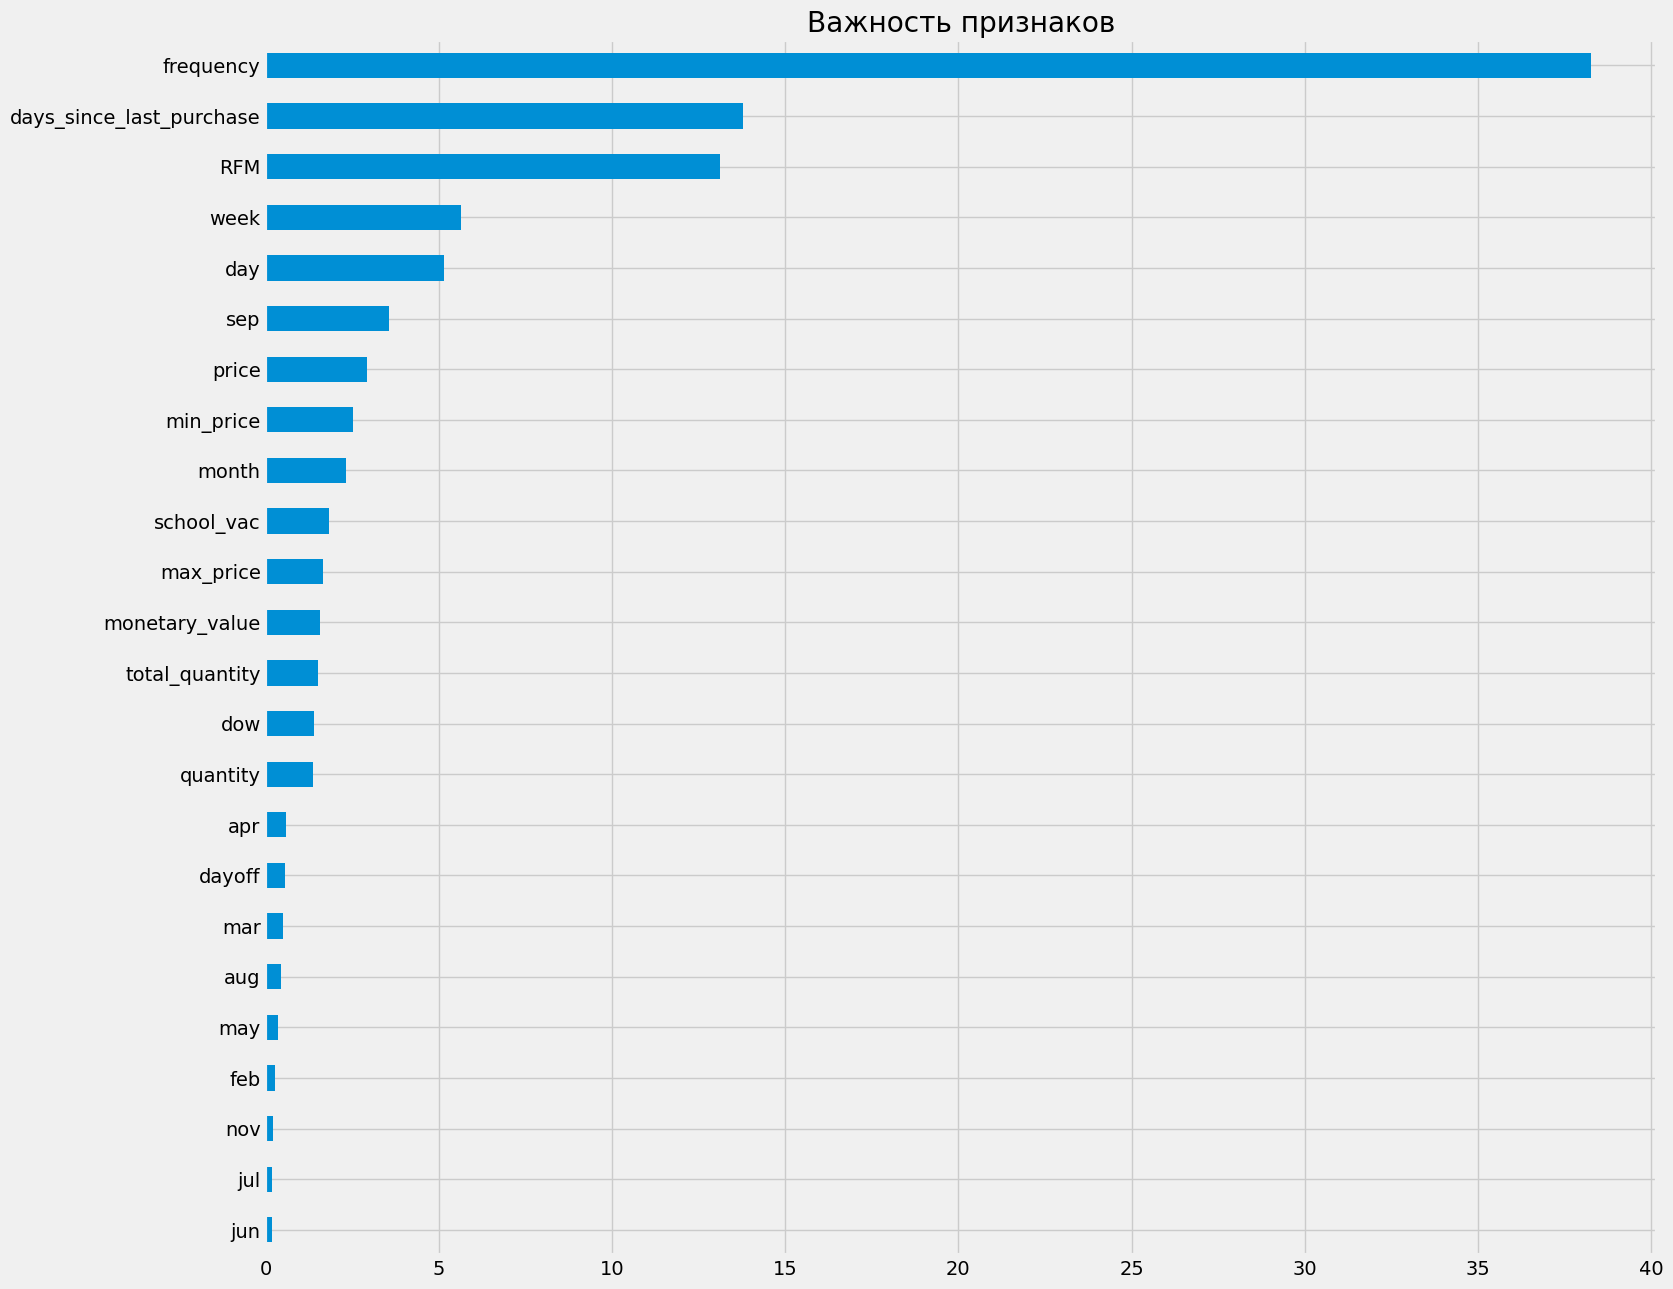

In [93]:
# построим гистограмму значимости признаков для модели CatBoost
# значения отсортированные по возрастанию влияния

plt.figure(figsize = (16,15))
importances = pd.Series(cb.feature_importances_,index=cb.feature_names_).sort_values()

# график
importances.plot.barh(grid=True, title='Важность признаков');

## 6. Тестирование модели на тестовой выборке

In [94]:
# Создаем test_pool для обучения
test_pool = Pool(X_test, y_test, cat_features=cat_features_test)

In [95]:
predict_test = cb.predict(X_test)

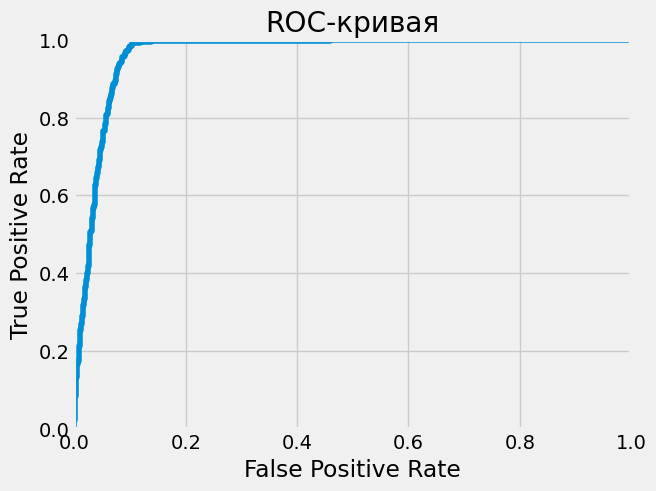

In [96]:
probabilities_test = cb.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 

In [97]:
print(classification_report(y_test,cb.predict(test_pool)))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      2210
           1       0.73      0.30      0.42       315

    accuracy                           0.90      2525
   macro avg       0.82      0.64      0.68      2525
weighted avg       0.89      0.90      0.88      2525



In [98]:
# рассчитаем дополнительные метрики
print(f'Accuracy: {accuracy_score(y_test, predict_test)}')    
print(f'Полнота: {recall_score(y_test, predict_test)}')     
print(f'Точность: {precision_score(y_test, predict_test)}')  
print(f'F1-мера: {f1_score(y_test,predict_test)}')          
print(f'AUC-ROC:{roc_auc_score(y_test,probabilities_one_test)}')

Accuracy: 0.899009900990099
Полнота: 0.2984126984126984
Точность: 0.734375
F1-мера: 0.4243792325056433
AUC-ROC:0.964642677583854


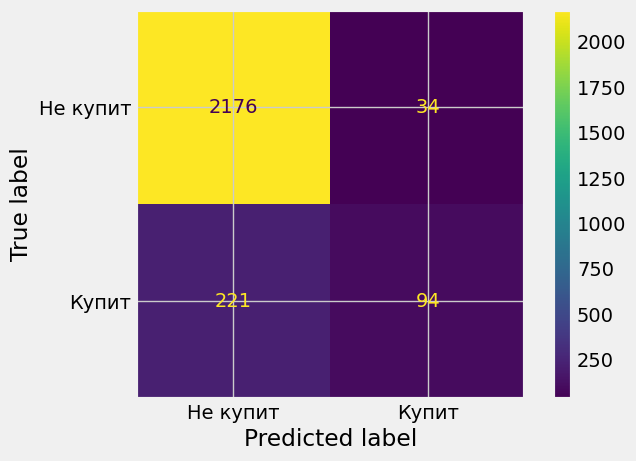

In [99]:
# выведем матрицу ошибок
cm = confusion_matrix(y_test,predict_test, labels=cb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels=['Не купит', 'Купит'])
disp.plot()
plt.show()

## 7. Рассмотрим работу нашей модели на примере с промокодами


Рассмотрим матрицу ошибок с точки зрения бизнеса.

Представим, что у нас есть промокод, который составляет 20% от стоимости ежемесячных услуг для каждого клиента. Поставим задачу так: кто собирается уходить, тому выдадим промокод, а кто лояльный, промокод не будем давать. У нас появятся ошибки первого и второго рода.

Ошибки первого рода:
предсказание модели 1, значение таргета 0, мы выдали промокод лояльному клиенту. 

Ошибки второго рода:
предсказание модели 0, значение таргета 1, не выдали промокод клиенту, который не склонен к покупке. 

Чтобы посчитать прибыль, рассмотрим такую схему:

если клиент на самом деле был лояльный, то мы потеряли 20% от стоимости месячного платежа (ошибка 1го рода) если клиент был отточный, а мы не дали ему промокод, то мы потеряем 100% от стоимости ежемесячного платежа (ошибка второго рода).

Рассчитаем убытки от выданных промокодов.

**Предсказания на тестовой выборке для модели CatBoost**

In [100]:
X_test['pred_cat'] = cb.predict(X_test)
X_test['target'] = y_test

In [101]:
final_test = X_test[['price','pred_cat','target']]
final_test

,price,pred_cat,target
0,25798.000000,0,0
1,14998.000000,0,0
2,6118.000000,0,0
3,2.000000,0,0
4,79998.000000,0,1
...,...,...,...
2520,6398.000000,0,0
2521,18983.714844,0,0
2522,59998.000000,0,0
2523,16998.000000,0,0


**Убытки от выданных промокодов лояльным клиентам**

In [102]:
final_test.loc[
    (final_test['pred_cat']!=final_test['target'])
    &
    (final_test['pred_cat'] == 1)
]['price'].sum()*PROMO


172742.71250000002

**Убытки от потери клиентов, которым не выдали промокодов**

In [103]:
final_test.loc[
    (final_test['pred_cat']!=final_test['target'])
    &
    (final_test['pred_cat']== 0)
]['price'].sum()*PROMO

1116501.1

**Вывод**  
Здесь мы рассчитали сколько потеряет магазин исходя из предположения того, что клиент принесет такую же прибыль как и в прошлый раз. Конечно, здесь лучше производить расчет на фиксированной стоимости, например, ежемесячной подписке клиента на услуги доставки маркетплейса. Тогда результат будет более корректным.

В нашем случае, учитывая специфику магазина и наличие огромного количества единоразовых клиентов, стоит сделать акцент на превращении таких клиентов в лояльные, путем различных маркетинговых стратегий.

**Рекомендации для бизнеса: как «перевести» результаты RFM-анализа в портреты и конкретные предложения 🔥:**

Допустим, прошло 30 день с тех пор, как клиент в последний раз размещал заказ, и ожидается, что он разместит еще один. Вот что вы можете сделать в течение следующей недели, чтобы повысить вероятность совершения покупки:

Отправляйте им персональные рекомендации по продуктам.
Предложите им код скидки.
Сообщайте им обо всех активных продажах, которые вы проводите.
А еще лучше — создайте сегмент клиентов, соответствующих схожим критериям, чтобы максимизировать рентабельность инвестиций в кампанию. Таким образом, любой, кто сделает заказ в ближайшие семь дней, может быть подтолкнут к концу воронки продаж.

Порадуйте своих самых ценных клиентов.
Вероятно, вы уже знаете, кто ваши самые большие траты, но это выглядит только ретроспективно. Прогнозируемый CLV позволяет увидеть общую ценность, которую клиент может принести вашему бизнесу. Это означает, что вы точно знаете, кого вознаградить, что продлит срок службы и ценность ваших самых заинтересованных контактов. Каковы способы масштабного вознаграждения чемпионов бренда?

Напомните им присоединиться к вашей программе лояльности.
Предоставьте им эксклюзивный или ранний доступ к продажам или продуктам.
Предложите им VIP-предложения, чтобы расширить их покупательную способность благодаря вашему бренду.


✔️ покупал давно - ходил часто - были хорошие чеки → разочарованный фанат → нужно реактивировать его лояльность → надо предложить ему в подарок то, что он покупал раньше чаще всего;

✔️ покупал давно - ходил редко - были огромные чеки → упущенный жирный клиент → деньги для него не проблема, важно внимание → «вы у нас часто покупали эти классные продукты, но давно не приходили - наверняка они закончились и мы для вас их заказали, приходите, наслаждайтесь»;

✔️ покупал недавно - покупает часто - хорошие чеки → лояльный клиент →  чувствует себя причастным к компании, она вписана в его график жизни → предложить вступить в VIP-клуб.



**Вывод по мультикатегорийному магазину**

В данном исследовании нам удалось подтверить гипотезу о том, что на активность покупателей прежде всего влияет частота совершения покупок и комплексный портрет (RFM признак). Также выявили, что имеет значение номер недели и номер дня когда была совершена покупка. Влияние остальных признаков показано на гистограмме значимости.

К сожалению, при обучении модели нам все же не удалось добиться адекватной полноты. На это влияет несбалансированность нашего таргета. У магазина очень мало постоянных клиентов, поэтому трудно качественно оценить их дальнейшее поведение.
Необходимо больше данных для анализа и работы по привлечению клиентов на долгосрочную основу.

Выше были даны рекомендации относительно возможных стратегий.

Исследование особенностей магазина одежды и подарков будет проводиться в отдельном ноутбуке.